In [1]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
from copy import deepcopy

# Naïve Bayes classifier

In [3]:
df = pd.read_csv("Train_F.csv")
del df['countyfips']
del df['countyname']

In [4]:
def handle_missing_data(df):
    
    """
    This function will replace all ' ?' values from data frame with maximum occuring
    from attribute from that particular attribute
    """
    for col in df.columns:
        col_set = df[col]
        counts = {}
        cnt = 0
        for attribute in col_set.unique():
            counts[attribute] = 0
            if attribute == ' ':
                cnt += 1
        if not cnt:
            continue
        for attribute in col_set:
            counts[attribute]+=1
        max_freq = ' '
        for attribute in col_set:
            if counts[max_freq]<counts[attribute]:
                max_freq = attribute
        for i in range(len(df[col])):
            if df[col][i] == ' ':
                df[col][i] = max_freq
    return df

In [5]:
def newList_from_df(df):
    
    newList = []
    for i in range(len(df)):
        blankList = []
        newList.append(blankList)
    i = 0
    for col in df.columns:
        i = 0
        for attribute in df[col]:
            newList[i].append(attribute)
            i = i + 1
    newList = np.array(newList)
        
    num_instance, num_feature = newList.shape
    
    X = []
    y = []
    
    for i in range(num_instance):
        X.append(newList[i][:num_feature-1])
        y.append(newList[i][num_feature-1])
    
    X = np.array(X)
    y = np.array(y)
    
    for i in range(len(y)):
        y[i] = y[i] - 1
    
    return X, y
    

## Handaling Missing Data
**Here missing value is replaced with most frequent val**

In [6]:
df = handle_missing_data(df)

## Encoding categorical values
**Categorical value is encoded using Label encoder**

In [7]:
labelencoder = LabelEncoder()
df['statename'] = labelencoder.fit_transform(df['statename'])
df.head()

,statename,predicted_deaths_by_october_06,predicted_deaths_by_october_07,predicted_deaths_by_october_08,predicted_deaths_by_october_09,predicted_deaths_by_october_10,predicted_deaths_by_october_11,predicted_deaths_by_october_12,severity_county_5-day
0,34,7348.2,7356.8,7366.0,7375.6,7385.8,7396.5,7407.8,3
1,34,7274.1,7283.5,7293.3,7303.7,7314.6,7326.1,7338.2,3
2,4,6667.5,6679.6,6691.9,6704.5,6717.4,6730.6,6744.3,3
3,14,5273.9,5287.0,5300.5,5314.3,5328.6,5343.3,5358.5,3
4,34,4970.3,4982.1,4994.5,5007.4,5021.1,5035.3,5050.2,3


In [8]:
X, y = newList_from_df(df)

## Normalisation of Data
**Normalizing from column 1 to column 8**

In [9]:
def normaliseMat(rows, stInd, endInd):
    """
    This function will normalise the data from stCol to endCol
    """
    rows_cp = np.copy(rows)
    
    for row in rows_cp:
        sum = 0.0
        for i in range(endInd-stInd+1):
            sum += row[i+stInd]
        
        sum = sum/(endInd-stInd+1)
        
        for i in range(endInd-stInd+1):
            row[i+stInd]/=sum;
            
    return rows_cp

In [10]:
X_std = normaliseMat(X, 1, 7)

## Spilting the data at random
**The data is spilted randomly with 80% Train and 20% Test**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size= 0.2, random_state=1810)

In [12]:
def get_params(X_train, y_train): 
    """
    Function to get the unique classes, number of classes and number of features in training data
    """
    num_examples, num_features = X_train.shape
    num_classes = len(np.unique(y_train))
    return num_examples, num_features, num_classes

In [13]:
num_examples, num_features, num_classes = get_params(X_train, y_train)

In [14]:
def get_stats_by_class(X_train, y_train, num_examples=num_examples, num_classes=num_classes): 
    """
    Get stats of dataset by the class
    """
    class_mean = {}
    class_var = {} 
    class_prior = {} 
    
    num_examples = len(X_train)
    
    for cls in range(num_classes): 
        X_cls = X_train[y_train == cls]
        class_mean[str(cls)] = np.mean(X_cls, axis=0)
        class_var[str(cls)] = np.var(X_cls, axis=0)
        class_prior[str(cls)] = X_cls.shape[0] / num_examples
        
    return class_mean, class_var, class_prior

In [15]:
def gaussian_density_function(X, mean, std, num_examples=num_examples, num_features=num_features, eps=1e-6): 
    
    num_exambles, num_features = X_train.shape
    const = -num_features/2 * np.log(2*np.pi) - 0.5 * np.sum(np.log(std + eps))
    probs = 0.5 * np.sum(np.power(X - mean, 2)/(std + eps),axis = 1)
    
    return const - probs

In [16]:
def class_probabilities(X, class_mean, class_var, class_prior, num_classes=num_classes):
    """
    calculate the probability of each class given the data
    """
    num_examples = X.shape[0]
    probs = np.zeros((num_examples, num_classes))

    for cls in range(num_classes): 
        prior = class_prior[str(cls)]
        probs_cls = gaussian_density_function(X, class_mean[str(cls)], class_var[str(cls)])
        probs[:, cls] = probs_cls + np.log(prior)
    return probs

In [17]:
def predict(X_test, X_train, y_train): 
    
    num_examples, num_features, num_classes = get_params(X_test, y_train)
    class_mean, class_std, class_prior = get_stats_by_class(X_train, y_train)
    probs = class_probabilities(X_test, class_mean, class_std, class_prior)
    
    return np.argmax(probs, 1)

## Calculating accuracy

In [18]:
def accuracy(X_test, X_train, y_train, y_test):
    
    my_preds = predict(X_test, X_train, y_train)
    cnt = 0.0
    
    for i in range(len(my_preds)):
        if my_preds[i] == y_test[i]:
            cnt+=1
            
    return cnt/len(my_preds)

In [19]:
accuracy(X_test, X_train, y_train, y_test)

0.575516693163752

## K-fold cross validation
**Here k is 5, i.e 5 fold cross validation is performed and Mean is printed**

In [20]:
def KFoldCrossVal(X, y):
        
    size = int(len(X)/5)
    arr = []
    
    for i in range(5):
        
        X_test = X[i*size:(i+1)*size]
        y_test = y[i*size:(i+1)*size]
        X_train= np.concatenate((X[:i*size], X[(i+1)*size:]))
        y_train= np.concatenate((y[:i*size], y[(i+1)*size:]))
                 
        new_accuracy = accuracy(X_test, X_train, y_train, y_test)
        
        arr.append(new_accuracy)
    arr = np.array(arr)
    return arr

In [21]:
arr = KFoldCrossVal(X_std, y)
print("Mean Accuracy is :" + str(np.mean(arr)))

Mean Accuracy is :0.46815286624203817


# Principle Component Analysis
**Selecting number of components by preserving 95% of total variance**

In [22]:
X, y = newList_from_df(df)

In [23]:
X_std = StandardScaler().fit_transform(X)

## Calculating Eigenvectors and Eigenvalues
**Eigen parameters are calculated from Standardized data**

In [24]:
mean_vec = np.mean(X_std, axis = 0)
cov_mat  = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [25]:
print('\nEigenvalues \n%s' %eig_vals)


Eigenvalues 
[7.00306479e+00 9.99378819e-01 1.03038460e-04 2.73693728e-07
 1.27480942e-08 6.72846654e-09 8.19130752e-09 7.44108040e-09]


In [26]:
# Make a list of (eigenvalue, eigenvector) tuples

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
7.003064792848317
0.9993788194556021
0.00010303846047465668
2.736937281386428e-07
1.2748094207161944e-08
8.191307518696842e-09
7.441080403439004e-09
6.72846653614261e-09


## calculating explained variance and plotting curve

In [27]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(var_exp)

[87.51044921362355, 12.488259356739437, 0.0012875708320770783, 3.420082750172944e-06, 1.593004611103413e-07, 1.0235875603209184e-07, 9.298390176321511e-08, 8.407906345490052e-08]


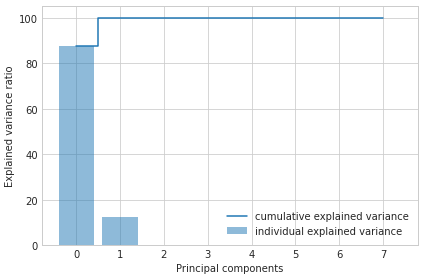

In [28]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(8), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(8), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()


The plot above clearly shows that most of the variance (87.51% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (12.48%) while the rest principal components can safely be dropped without losing too much information. Together, the first two principal components contain 99.99% of the information.


## Projection Matrix and Projecting in a new feature space
**Y=X×W**

In [29]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(8,1),
                      eig_pairs[1][1].reshape(8,1),))

In [30]:
Y = X_std.dot(matrix_w)

## Plotting scatter graph

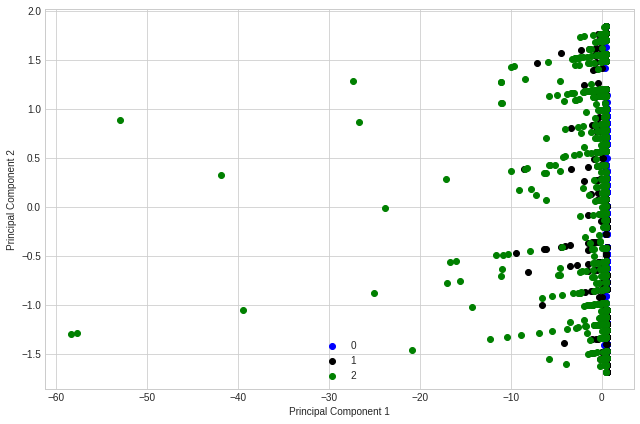

In [31]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    for lab, col in zip((0, 1, 2),
                        ('blue', 'black', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()


## K Fold Cross Validation

In [32]:
def KFoldCrossWithPCA(X,y):
    size = int(len(X)/5)
    arr = []
    
    for i in range(5):
        
        """Spiliting The Data"""
        
        X_test = X[i*size:(i+1)*size]
        y_test = y[i*size:(i+1)*size]
        X_train= np.concatenate((X[:i*size], X[(i+1)*size:]))
        y_train= np.concatenate((y[:i*size], y[(i+1)*size:]))
        
        """Applying PCA and transforming X_train and X_test"""
        
        # calculating the matrix W from train_data
        
        mean_vec = np.mean(X_train, axis = 0)
        cov_mat  = (X_train - mean_vec).T.dot((X_train - mean_vec)) / (X_train.shape[0]-1)
        eig_vals, eig_vecs = np.linalg.eig(cov_mat)
        
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        
        num_of_features = len(X[0])
        
        matrix_w = np.hstack((eig_pairs[0][1].reshape(num_of_features,1),
                              eig_pairs[1][1].reshape(num_of_features,1)),
                            )
        
        # transforming the matrix X_train and X_test using matrix_w
        
        X_train_pca = X_train.dot(matrix_w)
        X_test_pca  = X_test.dot(matrix_w)
            
        new_accuracy = accuracy(X_test_pca, X_train_pca, y_train, y_test)
                
        arr.append(new_accuracy)
        
    arr = np.array(arr)
    
    return arr
    

In [33]:
arrPCA = KFoldCrossWithPCA(X_std, y)
print("Mean Accuracy is :" + str(np.mean(arrPCA)))

Mean Accuracy is :0.4550955414012739


# Dropping samples with Maximum Outliner Features

In [34]:
def remove_OutLiner_Sample(X_train, y_train):
    outLiner = []

    class_mean = np.mean(X_train, axis = 0)
    class_var = np.var(X_train, axis = 0)

    mx_cnt = 0

    for i in range(len(X_train)):

        cnt = 0
        for j in range(len(X_train[i])):
            if X_train[i][j] > class_mean[j] + 3*(np.sqrt(class_var[j])):
                cnt += 1
        if cnt > mx_cnt:
            mx_cnt = cnt

        outLiner.append((cnt,i))

    for tup in outLiner:
        if tup[0] == mx_cnt:
            X_train = np.delete(X_train, tup[1], axis = 0)
            y_train = np.delete(y_train,tup[1])
            
    return X_train, y_train

**Removing Outliners Samples**

In [35]:
X, y = remove_OutLiner_Sample(X, y)

In [36]:
def criterion_func(X_test, X_train, y_train, y_test, feature):
    
    X_train_cp = np.copy(X_train)
    X_test_cp  = np.copy(X_test)
    
    y_train_cp = np.copy(y_train)
    y_test_cp  = np.copy(y_test)
    
    total = len(X_train_cp[0])
    
    
    for i in range(total):
        if i not in feature:
            X_train_cp = np.delete(X_train_cp, i, axis = 1)
            X_test_cp  = np.delete(X_test_cp, i, axis = 1)
    
    
    my_preds = predict(X_test_cp, X_train_cp, y_train_cp)
    
    cnt = 0.0
    
    
    for i in range(len(my_preds)):
        if my_preds[i] == y_test_cp[i]:
            cnt+=1
            
    return cnt/len(my_preds)

# Sequential Backward Selection

In [37]:
def SBS(X_train, X_test, y_train, y_test):
    
    features = []
    for i in range(len(X_train[0])):
        features.append(i)
    
    feat_sub = deepcopy(features)
    
    while len(feat_sub) != 0:
        
            
        curr_acc = criterion_func(X_test, X_train, y_train, y_test, feat_sub)
        flag = 0
        worst_feat = len(feat_sub)-1
        max_acc = criterion_func(X_test, X_train, y_train, y_test,feat_sub[:-1])
        
        if max_acc >=curr_acc:
            flag = 1
        
        for i in reversed(range(0,len(features)-1)):
            
            crit_func_eval = criterion_func(X_test, X_train, y_train, y_test, feat_sub[:i] + feat_sub[i+1:])
            if crit_func_eval > max_acc:
                worst_feat, max_acc = i, crit_func_eval
            if max_acc >= curr_acc:
                flag = 1
                
        if flag == 0:
            break       
            
        feat_sub = np.delete(feat_sub, worst_feat)
        
        return feat_sub, curr_acc

## K Fold Cross Validation

In [38]:
def KFoldCrossValSBS(X, y):
        
    size = int(len(X)/5)
    arr = []
    
    for i in range(5):
        
        X_test = X[i*size:(i+1)*size]
        y_test = y[i*size:(i+1)*size]
        X_train= np.concatenate((X[:i*size], X[(i+1)*size:]))
        y_train= np.concatenate((y[:i*size], y[(i+1)*size:]))
                
        feat_sub, new_accuracy = SBS(X_train, X_test, y_train, y_test)
        
        print('feature Set obtained and accuracy:', feat_sub, new_accuracy)
            
        new_accuracy = criterion_func(X_test, X_train, y_train, y_test, feat_sub)
        
        arr.append(new_accuracy)
    arr = np.array(arr)
    return arr

In [39]:
X_std = normaliseMat(X, 1, 7)

In [40]:
arrSBS = KFoldCrossValSBS(X_std, y)
print("\nMean Accuracy is :" + str(np.mean(arrSBS)))

feature Set obtained and accuracy: [0 1 2 3 4 5 6] 0.6096774193548387
feature Set obtained and accuracy: [0 1 2 3 4 5 6] 0.4403225806451613
feature Set obtained and accuracy: [0 1 2 3 4 6 7] 0.3
feature Set obtained and accuracy: [0 1 2 3 4 5 6] 0.1935483870967742
feature Set obtained and accuracy: [1 2 3 4 5 6 7] 0.8419354838709677

Mean Accuracy is :0.4829032258064515
